In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

In [2]:
def get_regression_np(_R):
    data = pd.concat([DB2, _R],
                     axis=0, 
                     ignore_index=True
                    )
    Y_ = data[["TAUTH"]].to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs]; _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

In [3]:
# REMARK: There are no spherical TOKAMAKs in these analyses.  

DB2P8 = pd.read_csv("../data/DB2P8.csv")
DB5 = pd.read_csv("../data/DB5.csv")

DB2P8 = DB2P8[DB5.columns]

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv("../data/new_point_ids.csv")
                  
R = pd.read_csv("../data/R.csv")#DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

In [4]:
subset_ids = pd.read_csv("../data/R_ids_alpha_0.9576.csv")
R = R[R.id.isin(subset_ids.id.values)][["TAUTH"] + coeffs + ["id"]] 
R = R.reset_index(drop=True)

In [5]:
# Getting both DataFrames together: points that decreased the regression

data, regression, NP = get_regression_np(R)
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     5176.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:32:17   Log-Likelihood:                 362.97
No. Observations:                2622   AIC:                            -707.9
Df Residuals:                    2613   BIC:                            -655.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2914      0.040    -57.689      0.000      -2.369      -2.214
x1             1.2662      0.024     53.588      0.000       1.220       1.313
x2             0.1452      0.021      7.024      0.000       0.105       0.186
x3            -0.0643      0.015     -4.356      0.000      -0.093      -0.035
x4            -0.6000      0.012    -48.900      0.000      -0.624      -0.576
x5             0.9576      0.037     25.772      0.000       0.885       1.030
x6             0.2424      0.039      6.184      0.000       0.166       0.319
x7            -0.2632      0.050     -5.255      0.000      -0.361      -0.165
x8             0.0970      0.031      3.164      0.002       0.037       0.157
==============================================================================
Omnibus:                        0.522   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.581
Skew:                           0.016   Prob(JB):                        0.748
Kurtosis:                       2.934   Cond. No.                         53.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
influence = regression.get_influence()
infl_summary = influence.summary_frame()

## DFBETAs Analysis to `R_ids_alpha_0.9622.csv`

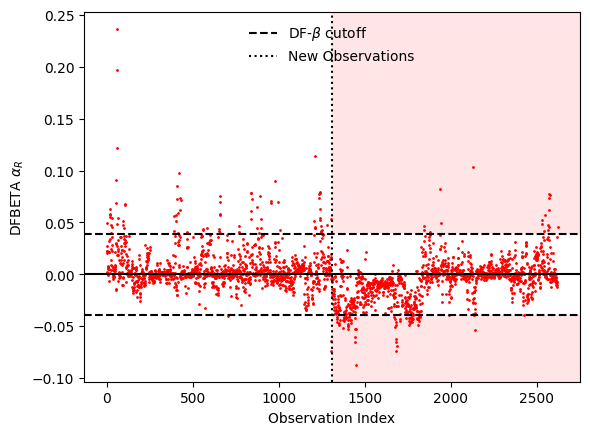

In [7]:
dfbeta_cutoff =  2/(NP[0])**(0.5)
DBβ_αR = infl_summary["dfb_x5"]

plt.scatter(list(range( len(R)+len(DB2) )), DBβ_αR.values, s=1, c="r")
plt.axhline(dfbeta_cutoff, c="k", ls="--", label="DF-$\\beta$ cutoff")
plt.axhline(-dfbeta_cutoff, c="k", ls="--")
plt.axhline(0, c="k")
plt.axvline( data[len(DB2P8):].iloc[0].name, c="k", ls=":", label="New Observations")
plt.xlabel("Observation Index")
plt.ylabel("DFBETA $\\alpha_R$")
plt.legend(loc="upper center", frameon=False)


left, bottom, width, height = (data[len(DB2):].iloc[0].name, 
                               -dfbeta_cutoff, 
                               len(data), 
                               min(DBβ_αR.values)
                              )
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

left, bottom, width, height = (data[len(DB2):].iloc[0].name, 
                               dfbeta_cutoff, 
                               len(data), 
                               max(DBβ_αR.values)
                              )
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect);

In [8]:
infl_DB5 = DBβ_αR.iloc[len(DB2):]
upper_pts_αR = infl_DB5[(infl_DB5 >=  dfbeta_cutoff)].index
lower_pts_αR = infl_DB5[(infl_DB5 <= -dfbeta_cutoff)].index

infl_pts_αR = list(upper_pts_αR) + list(lower_pts_αR)
id_infl_pts_αR = data.iloc[infl_pts_αR]["id"].values

In [9]:
# Getting both DataFrames together: influential | maximizes
R_αR_infl =  R[R.id.isin(id_infl_pts_αR)]

data_infl_αR, regression_infl_αR, NP_infl_αR = get_regression_np(R_αR_infl)
regression_infl_αR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     3778.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:32:22   Log-Likelihood:                 297.22
No. Observations:                1400   AIC:                            -576.4
Df Residuals:                    1391   BIC:                            -529.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7520      0.053    -52.302      0.000      -2.855      -2.649
x1             0.9831      0.028     35.025      0.000       0.928       1.038
x2             0.2432      0.028      8.770      0.000       0.189       0.298
x3             0.2227      0.022     10.305      0.000       0.180       0.265
x4            -0.6032      0.015    -40.006      0.000      -0.633      -0.574
x5             1.6836      0.052     32.455      0.000       1.582       1.785
x6             0.2831      0.046      6.166      0.000       0.193       0.373
x7             0.2028      0.059      3.451      0.001       0.088       0.318
x8             0.1775      0.036      4.922      0.000       0.107       0.248
==============================================================================
Omnibus:                       50.738   Durbin-Watson:                   0.619
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.834
Skew:                          -0.154   Prob(JB):                     3.50e-27
Kurtosis:                       4.412   Cond. No.                         46.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Getting both DataFrames together: influential | minimizes
R_αR_not_infl =  R[~R.id.isin(id_infl_pts_αR)]

data_not_infl_αR, regression_not_infl_αR, NP_not_infl_αR = get_regression_np(R_αR_not_infl)
regression_not_infl_αR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     5466.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:32:22   Log-Likelihood:                 451.88
No. Observations:                2532   AIC:                            -885.8
Df Residuals:                    2523   BIC:                            -833.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3020      0.039    -59.532      0.000      -2.378      -2.226
x1             1.2157      0.024     51.229      0.000       1.169       1.262
x2             0.1439      0.021      6.886      0.000       0.103       0.185
x3            -0.0161      0.015     -1.088      0.277      -0.045       0.013
x4            -0.6059      0.012    -50.021      0.000      -0.630      -0.582
x5             1.0539      0.038     27.948      0.000       0.980       1.128
x6             0.2485      0.039      6.392      0.000       0.172       0.325
x7            -0.1578      0.050     -3.169      0.002      -0.255      -0.060
x8             0.0889      0.030      2.966      0.003       0.030       0.148
==============================================================================
Omnibus:                        2.582   Durbin-Watson:                   0.577
Prob(Omnibus):                  0.275   Jarque-Bera (JB):                2.517
Skew:                           0.075   Prob(JB):                        0.284
Kurtosis:                       3.038   Cond. No.                         55.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Influential Pts Analysis to `data`: `R_ids_alpha_0.9576.csv`

In [11]:
infl_summary

,dfb_const,dfb_x1,dfb_x2,dfb_x3,dfb_x4,dfb_x5,dfb_x6,dfb_x7,dfb_x8,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.018919,-0.031627,0.020989,0.007390,0.004769,0.022268,-0.006731,0.025412,-0.009103,0.000520,1.388519,0.002423,0.068428,1.388765,0.068440
1,0.020444,-0.034530,0.022403,0.003675,0.012487,0.020404,-0.008796,0.026112,-0.010029,0.000615,1.476532,0.002531,0.074375,1.476866,0.074392
2,0.018212,-0.017685,0.018358,0.008769,-0.020720,0.022207,0.003585,0.020945,-0.004564,0.000261,0.930483,0.002705,0.048461,0.930459,0.048460
3,0.035102,-0.045975,0.037597,0.025996,-0.028871,0.049579,0.000447,0.048425,-0.011638,0.001185,2.015125,0.002619,0.103258,2.016307,0.103319
4,0.024064,-0.043323,0.027250,0.008560,0.013594,0.027445,-0.010465,0.033615,-0.012148,0.000897,1.758796,0.002602,0.089837,1.759501,0.089873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617,0.011885,0.003085,-0.018741,0.005683,0.008673,-0.007228,-0.007398,0.002142,-0.003116,0.000229,0.477514,0.008964,0.045415,0.477444,0.045408
2618,0.012253,0.004660,-0.018289,0.004490,0.007024,-0.007490,-0.009023,0.001308,-0.002129,0.000195,0.442257,0.008909,0.041932,0.442188,0.041925
2619,0.020188,0.005476,-0.028162,0.005480,0.012424,-0.012373,-0.009199,0.003053,-0.004812,0.000554,0.756732,0.008628,0.070594,0.756670,0.070588
2620,0.034450,-0.044516,0.059760,-0.001560,-0.006460,0.035673,0.008970,0.054727,0.011153,0.000676,0.833744,0.008681,0.078021,0.833695,0.078016


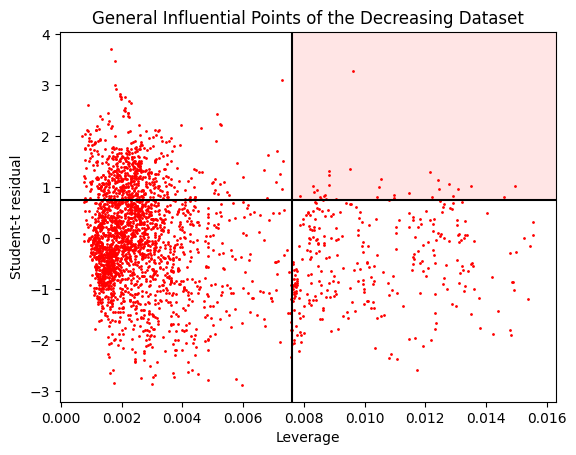

In [12]:
student_resid = influence.resid_studentized_external
leverage = influence.hat_matrix_diag
cutoff_leverage = ((2*NP[1])+2)/NP[0]
cutoff_student_resid = 0.75


plt.scatter(leverage, student_resid, s=1, c="r")
plt.ylabel("Student-t residual")
plt.xlabel("Leverage")
plt.axvline(cutoff_leverage, c="k")
plt.axhline(cutoff_student_resid, c="k")

left, bottom, width, height = cutoff_leverage, cutoff_student_resid, max(leverage), max(student_resid)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)
plt.title("General Influential Points of the Decreasing Dataset");

In [13]:
ge_infl = (pd.DataFrame([leverage,student_resid]).T).rename(columns={0:"leverage",1:"t_resid"})
ge_infl = ge_infl[ge_infl.leverage > cutoff_leverage]
ge_infl = ge_infl[ge_infl.t_resid  > cutoff_student_resid]

# Influential points found from DB5 dataset
ge_infl_DB5 = ge_infl[ge_infl.index  >= len(DB2)]
infl_DB5_ids = data[data.index.isin(ge_infl_DB5.index)].id.values

In [14]:
# Getting both DataFrames together | influential to maximize

R_infl =  R[R.id.isin( infl_DB5_ids )]

data_infl, regression_infl, NP_infl = get_regression_np(R_infl)
regression_infl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     5641.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:32:22   Log-Likelihood:                 561.34
No. Observations:                1324   AIC:                            -1105.
Df Residuals:                    1315   BIC:                            -1058.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8843      0.045    -63.500      0.000      -2.973      -2.795
x1             0.8117      0.025     32.512      0.000       0.763       0.861
x2             0.2581      0.025     10.227      0.000       0.209       0.308
x3             0.4156      0.019     21.489      0.000       0.378       0.454
x4            -0.6520      0.013    -51.372      0.000      -0.677      -0.627
x5             2.1245      0.048     44.693      0.000       2.031       2.218
x6             0.3456      0.040      8.649      0.000       0.267       0.424
x7             0.5608      0.050     11.184      0.000       0.462       0.659
x8             0.1760      0.030      5.894      0.000       0.117       0.235
==============================================================================
Omnibus:                       31.035   Durbin-Watson:                   0.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.310
Skew:                          -0.235   Prob(JB):                     1.45e-10
Kurtosis:                       3.774   Cond. No.                         49.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Getting both DataFrames together | not influential to maximize

R_not_infl = R[~R.id.isin( infl_DB5_ids )]

data_not_infl, regression_not_infl, NP_not_infl = get_regression_np(R_not_infl)
regression_not_infl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     5138.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:32:22   Log-Likelihood:                 360.36
No. Observations:                2608   AIC:                            -702.7
Df Residuals:                    2599   BIC:                            -649.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3023      0.040    -57.659      0.000      -2.381      -2.224
x1             1.2706      0.024     53.537      0.000       1.224       1.317
x2             0.1475      0.021      7.063      0.000       0.107       0.188
x3            -0.0679      0.015     -4.574      0.000      -0.097      -0.039
x4            -0.5974      0.012    -48.104      0.000      -0.622      -0.573
x5             0.9466      0.038     25.201      0.000       0.873       1.020
x6             0.2388      0.039      6.081      0.000       0.162       0.316
x7            -0.2790      0.050     -5.532      0.000      -0.378      -0.180
x8             0.0969      0.031      3.144      0.002       0.036       0.157
==============================================================================
Omnibus:                        0.529   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.585
Skew:                           0.024   Prob(JB):                        0.746
Kurtosis:                       2.945   Cond. No.                         54.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# #points: αR: cutoff t residual
"""
1274: 0.9515: st_cutoff = 0.2
1288: 0.9481: st_cutoff = 0.5
1294: 0.9473: st_cutoff = 0.6
1297: 0.9465: st_cutoff = 0.7
1298: 0.9459: st_cutoff = 0.75 ****
1303: 0.9481: st_cutoff = 0.7
""";

In [17]:
len(subset_ids) # points that gave 0.9576 from previous analysis

1312

In [18]:
# This suggests that maybe a loop or a while could be used to investigate the decrease of 
# this parameter with respect to the previous improved subset and the tuned student-t parameter. 